In [1]:
import numpy as np, matplotlib.pyplot as plt
import threading,time, queue, pyaudio 
from matplotlib.pyplot import *
import matplotlib.cm as cm
from scipy import signal
from threading import Lock

## Frequency Response Finder

This script can be used to find the (combined) frequency response of your microphone and speakers

It works by sweeping a tone across the range of human hearing (20Hz to 20kHz) being outputted at a constant volume, then detecting at which frequencies it is lower/higher

In [2]:
def linSweepChirp(f0, f1, T, fs):
    
    t = np.r_[0:T:1/fs]
    phi = (((f1-f0)/T)/2)*t**2 + f0*t
    
    return np.sin(2*np.pi*phi)

def norm(x):
    xmax = x[np.argmax(x)]
    return x/xmax

Text(0.5,0,'Frequency [Hz]')

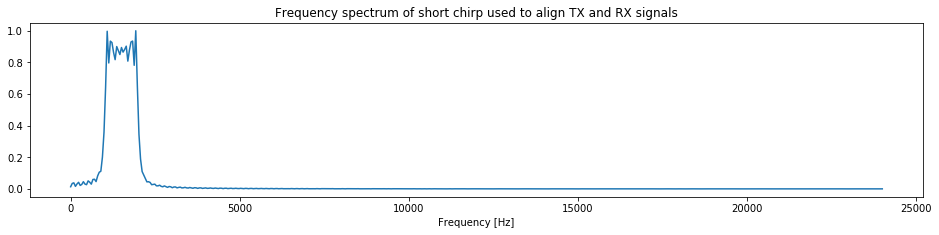

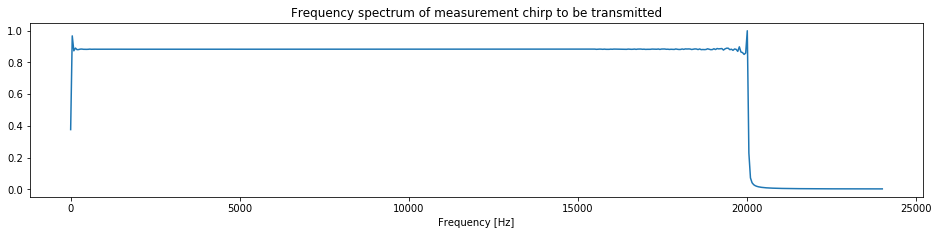

In [14]:

fs = 48000
Talign = 0.1
Ttest = 20
alignmentChirp = linSweepChirp(1000, 2000, Talign, fs)
measurementChirp = linSweepChirp(20, 20000, Ttest, fs)

w, alignmentChirpFreq = signal.freqz(alignmentChirp)
w, measurementChirpFreq = signal.freqz(measurementChirp)

#Plotting
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,fs/2,alignmentChirpFreq.size),norm(abs(alignmentChirpFreq)))
plt.title("Frequency spectrum of short chirp used to align TX and RX signals")
plt.xlabel("Frequency [Hz]")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,fs/2,measurementChirpFreq.size),norm(abs(measurementChirpFreq)))
plt.title("Frequency spectrum of measurement chirp to be transmitted")
plt.xlabel("Frequency [Hz]")

In [15]:
#pyaudio code from Craig Jin, ELEC3305 lecturer at USyd
def play_audio( Q, p, fs , dev=None):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data is "EOT" :
            break
        try:
            ostream.write( data.astype(np.float32).tostring() )
        except:
            break
            
def record_audio( queue, p, fs ,dev=None,chunk=2048,lock=None):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) #
    # p.terminate() # terminate pyAudio
    
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is destroyed, stops
            with lock if lock is not None else 1:
                data_str = istream.read(chunk, exception_on_overflow=False) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def xciever(sig, fs):
    # function takes a signal and a sampling frequency
    # it then plays and records at the same time. The function returns
    # the recorded sound.

    rcv = [];

    # create an input output FIFO queues
    Qin = queue.Queue()
    Qout = queue.Queue()

    #lock for controlling access to shared resources
    lock = Lock()
    
    # create a pyaudio object
    p = pyaudio.PyAudio()

    # initialize a recording thread.
    t_rec = threading.Thread(target = record_audio,   args = (Qin, p, fs ), kwargs={'lock': lock})
    t_play_audio = threading.Thread(target = play_audio,  args = (Qout, p, fs  ))

    # start the recording and playing threads
    t_rec.start()
    t_play_audio.start()

    Qout.put( sig );
    Qout.put( "EOT" );

    # pause for RECORD_SECS seconds
    RECORD_SECS = len(sig)/fs + 2.0
    time.sleep( RECORD_SECS )
    # terminate pyAudio
    with lock:
        p.terminate()
        
    # append to output
    while ( not Qin.empty()) :
        data = Qin.get()
        rcv = np.append( rcv, data )

    return rcv

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:54: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead


Text(0.5,0,'Time [s]')

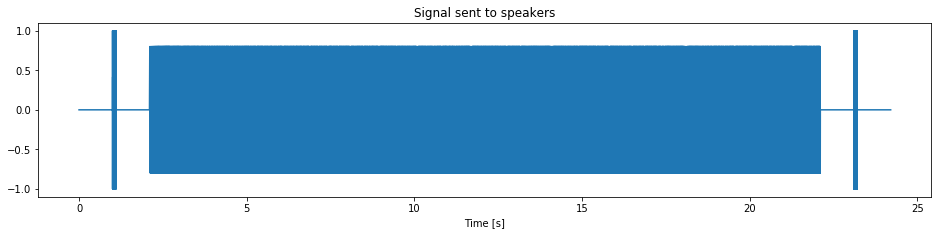

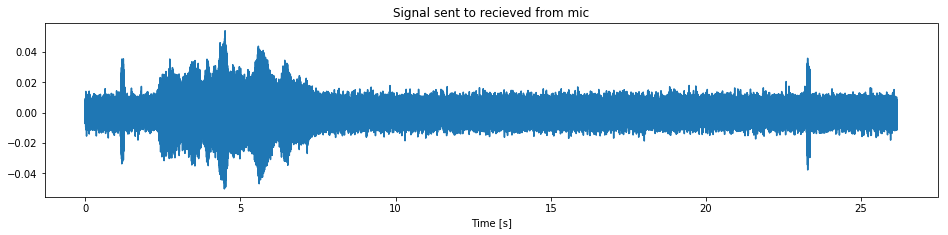

In [16]:

testSignal = np.zeros(fs)
testSignal = np.concatenate((testSignal,alignmentChirp))
testSignal = np.concatenate((testSignal,np.zeros(fs)))
measureSigStart = testSignal.size
testSignal = np.concatenate((testSignal,0.8*measurementChirp))
testSignal = np.concatenate((testSignal,np.zeros(fs)))
testSignal = np.concatenate((testSignal,alignmentChirp))
testSignal = np.concatenate((testSignal,np.zeros(fs)))

measured = xciever(testSignal, fs)

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,testSignal.size/fs,testSignal.size),testSignal)
plt.title("Signal sent to speakers")
plt.xlabel("Time [s]")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,measured.size/fs,measured.size),measured)
plt.title("Signal sent to recieved from mic")
plt.xlabel("Time [s]")

First thing to do is extract the measurement pulse, this is done through cross correlation to first find the delay between TX and RX signals. The alignment pulses at each end here help get a good result even with all the background noise.

Text(0.5,1,'Measurement chirp, extracted from recieved signal')

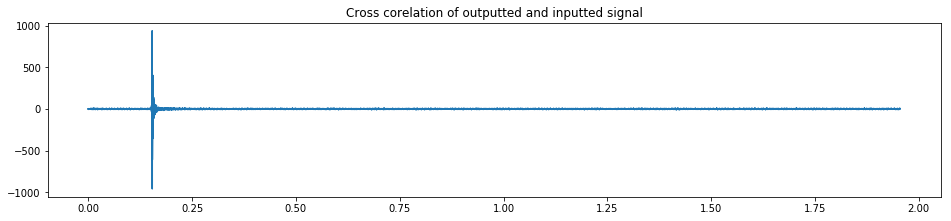

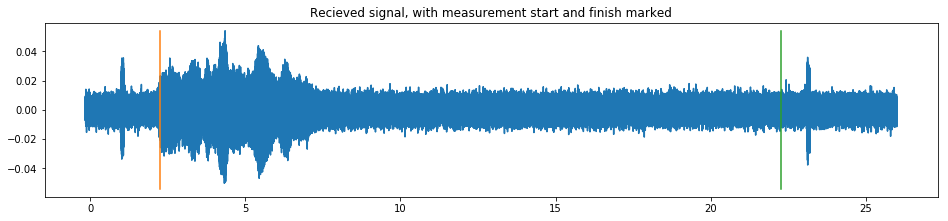

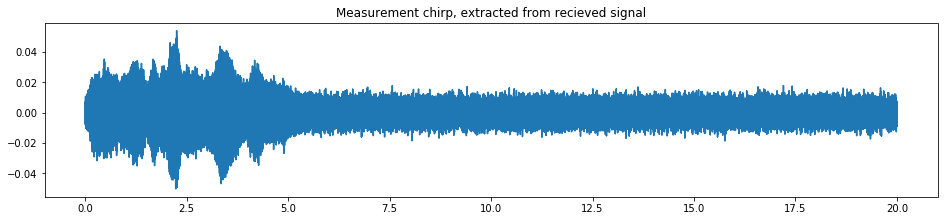

In [17]:
meas_xcor = signal.convolve(measured, testSignal[::-1], mode='valid')
recShift = np.argmax(meas_xcor)

rcvMeasureChirp = np.zeros(measurementChirp.size) 
mStart = (recShift+measureSigStart)
mFin = (recShift+measureSigStart+measurementChirp.size)
rcvMeasureChirp[:] = measured[mStart:mFin]

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,meas_xcor.size/fs,meas_xcor.size),meas_xcor)
plt.title("Cross corelation of outputted and inputted signal")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,measured.size/fs,measured.size)-(recShift/fs),measured)
plt.plot([mStart/fs,mStart/fs],[-1*measured[np.argmax(measured)],1*measured[np.argmax(measured)]])
plt.plot([(mFin)/fs,(mFin)/fs],[-1*measured[np.argmax(measured)],1*measured[np.argmax(measured)]])
plt.title("Recieved signal, with measurement start and finish marked")

width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(np.linspace(0,rcvMeasureChirp.size/fs,rcvMeasureChirp.size),rcvMeasureChirp)
plt.title("Measurement chirp, extracted from recieved signal")

Text(0,0.5,'Magnitude difference [dBa]')

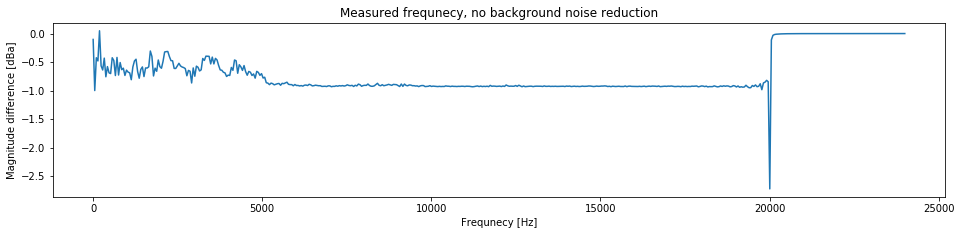

In [20]:
w, measuredFreq = signal.freqz(rcvMeasureChirp)
measuredFIndex = np.linspace(0,fs/2, measuredFreq.size)

freqResp = norm(np.abs(measuredFreq)) - norm(np.abs(measurementChirpFreq))
width, height = plt.figaspect(0.2)
fig = plt.figure(figsize=(width,height))
plt.plot(measuredFIndex,np.log10(freqResp+1))

plt.title("Measured frequnecy, no background noise reduction")
plt.xlabel("Frequnecy [Hz]")
plt.ylabel("Magnitude difference [dBa]")

This technique does have a few limitations however, ideally at each point in time all other frequncies other than the one being transmitted would be filtered out, leaving only the magnitude of the currently transmitted signal at that point in time.